# Leukemia Classification Using Machine Learning

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm

## Load data

In [4]:
data_dir = "Dataset/Original"

# Load the data in images

def load_data(data_dir):
    data = []
    labels = []
    for label in os.listdir(data_dir):
        for img_name in os.listdir(os.path.join(data_dir, label)):
            img = Image.open(os.path.join(data_dir, label, img_name))
            data.append(img)
            labels.append(label)
    return data, labels

images, labels = load_data(data_dir)

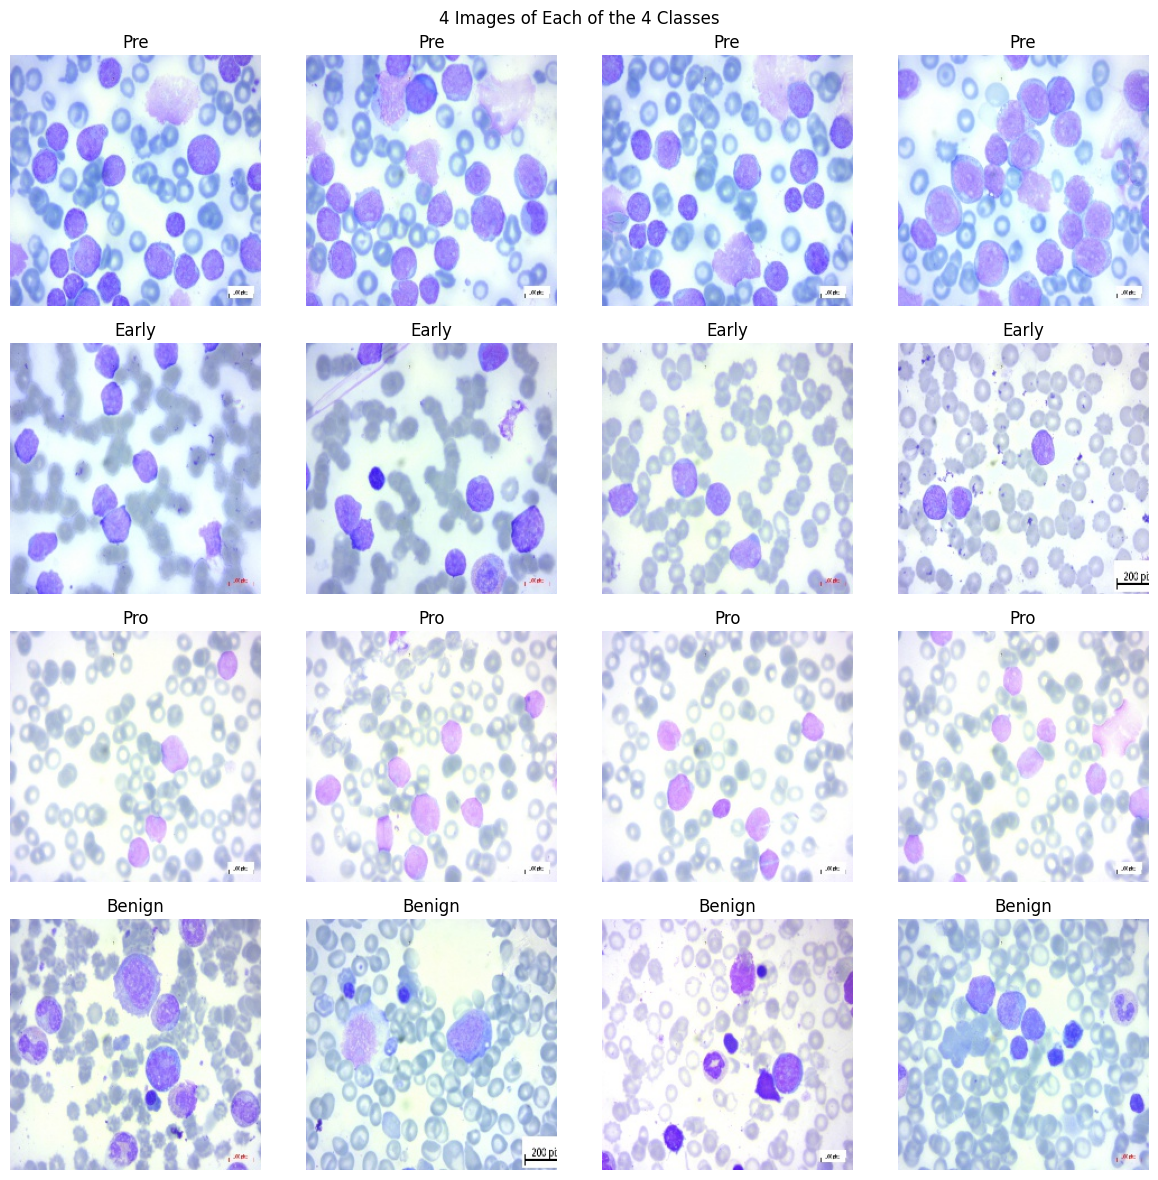

In [5]:
# Create a dictionary to store images by their labels
label_to_images = {}
for img, label in zip(images, labels):
    if label not in label_to_images:
        label_to_images[label] = []
    label_to_images[label].append(img)

# Visualize 4 images of each of the 4 classes
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('4 Images of Each of the 4 Classes')

for i, (label, imgs) in enumerate(label_to_images.items()):
    for j in range(4):
        axes[i, j].imshow(imgs[j])
        axes[i, j].set_title(label)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
np.unique(y)

array([0, 1, 2, 3])

In [7]:
features = np.load('embeddings.npy')

## Analyze embeddings

### t-SNE visualization

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

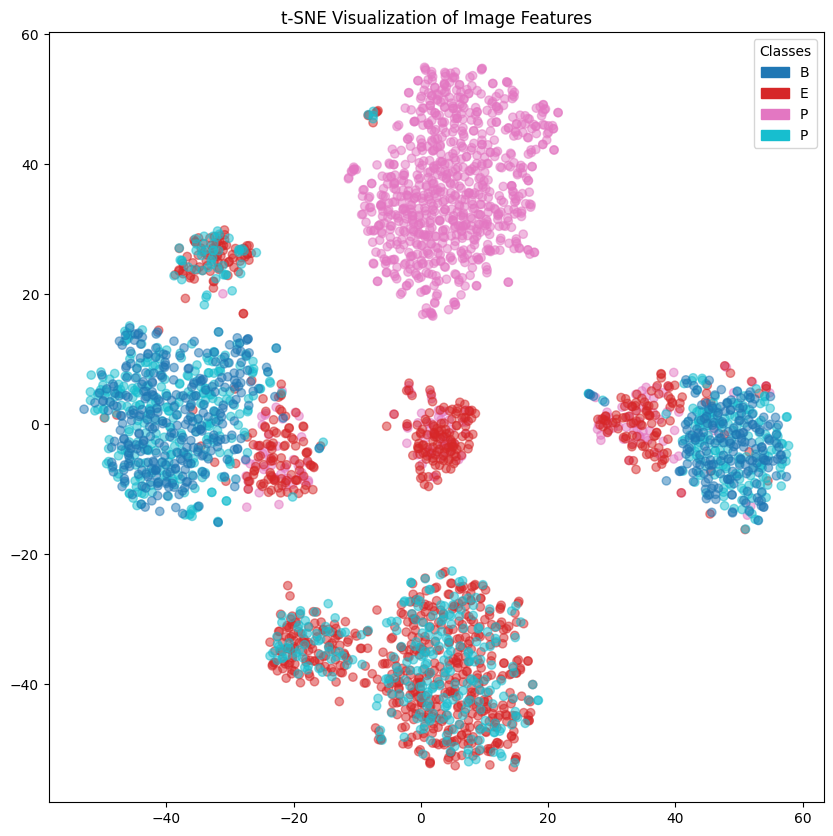

In [8]:
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y, cmap='tab10', alpha=0.5)
plt.title('t-SNE Visualization of Image Features')

classes = np.unique(y)
class_labels = le.inverse_transform(classes)

handles = []
for i, class_label in enumerate(classes):
    color = scatter.cmap(scatter.norm(i))  # Get the color from the scatter plot colormap
    class_name = class_labels[i][0]  # Get the class name
    handle = mpatches.Patch(color=color, label=class_name)  # Create a patch for the legend
    handles.append(handle)

# Add legend to the plot
plt.legend(handles=handles, loc='upper right', title='Classes')


t-SNE is a non linear dimensionality reduction technique. Here we can see that while one class is nearly ompletely separate others are still mixed up for n = 2.

### PCA reduction and visualization

Text(0.5, 0, 'Principal Component')

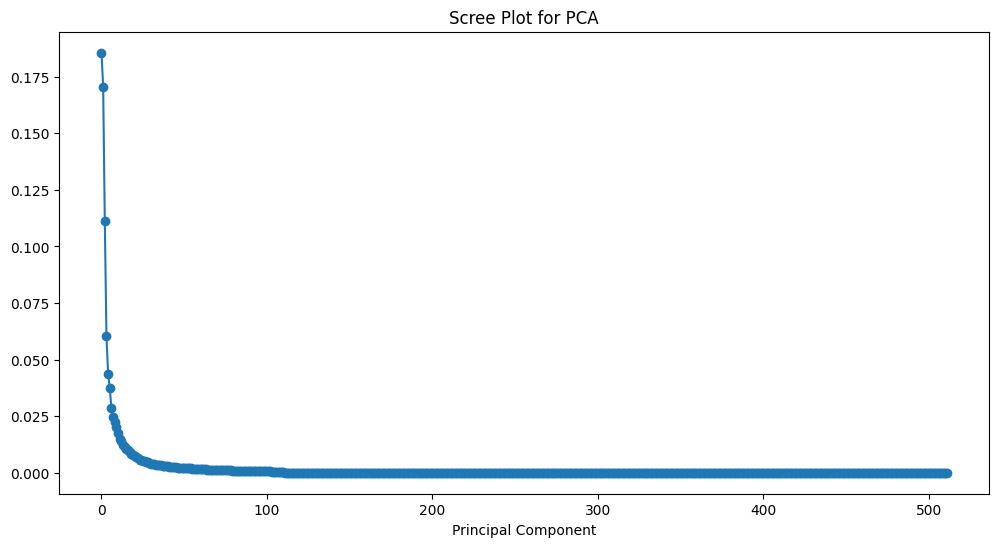

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
features_pca = pca.fit_transform(features)

# scree plot
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')

Most of the variance can be explained by a few PCs as shown in the scree plot.

Text(0.5, 1.0, 'Scree Plot for PCA')

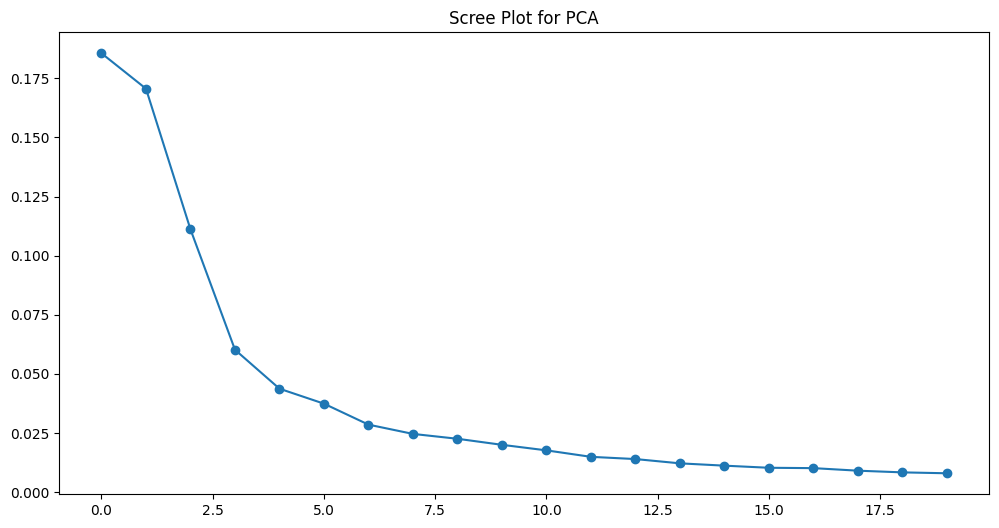

In [10]:
pca = PCA(n_components=20)
features_pca = pca.fit_transform(features)

# scree plot
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot for PCA')

Text(0.5, 1.0, 'PCA Visualization of Image Features')

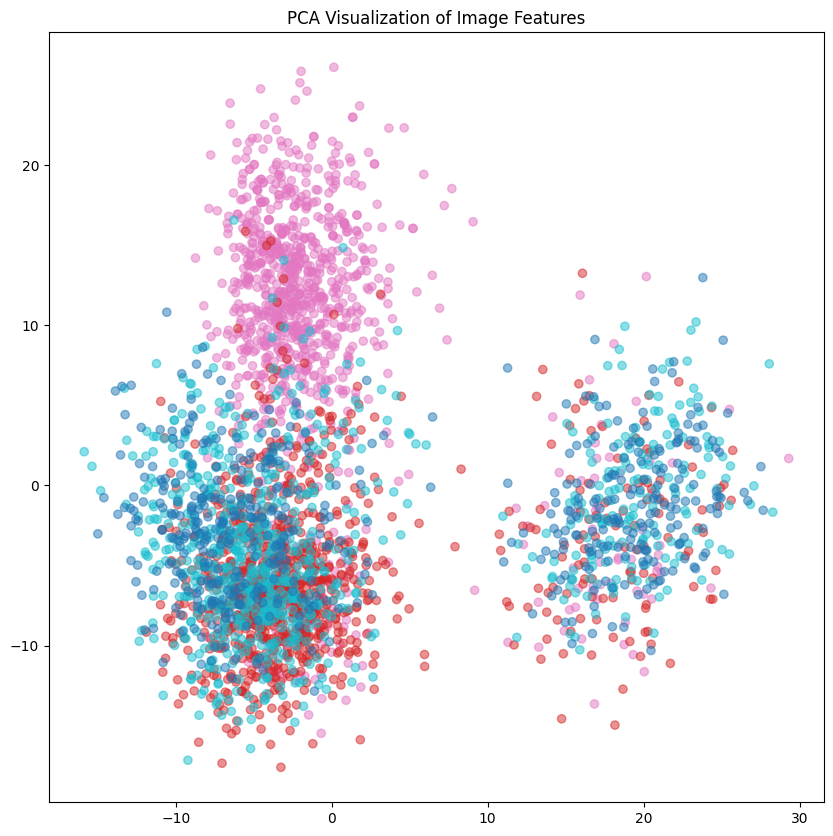

In [11]:
# visualize the first two principal components
plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Image Features')


10 features seem to be enough to explain most of the variance in the data. PCA visualization does not really give much information.

### Correlation of embeddings with target

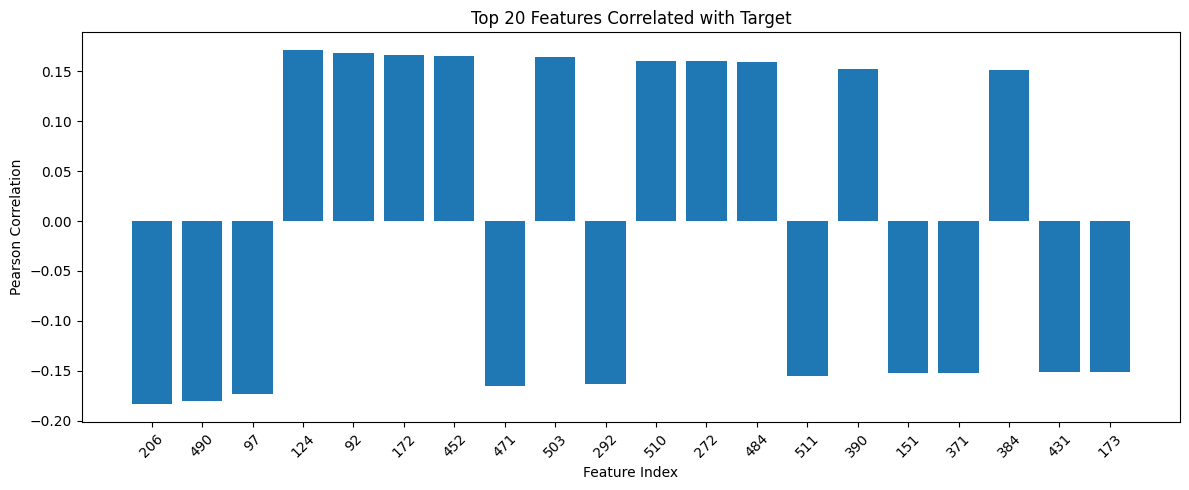

In [12]:
from scipy.stats import pearsonr, spearmanr

correlations = []
for i in range(features.shape[1]):
    corr, _ = pearsonr(features[:, i], y)
    correlations.append(corr)

correlations = np.array(correlations)

# sort the features by correlation in descending order
sorted_indices = np.argsort(-np.abs(correlations))  # Note the negative sign
sorted_correlations = correlations[sorted_indices]

# plot top 20 features
plt.figure(figsize=(12, 5))
plt.bar(np.arange(20), sorted_correlations[:20])  # Take first 20 instead of last 20
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Feature Index')
plt.ylabel('Pearson Correlation')

# feature index positions
feature_names = np.array(range(features.shape[1]))
top_feature_indices = sorted_indices[:20]  # Take first 20
top_feature_names = feature_names[top_feature_indices]

# write on the x axis
plt.xticks(np.arange(20), top_feature_names, rotation=45)
plt.tight_layout()  # Prevent label cutoff

### Feature importance

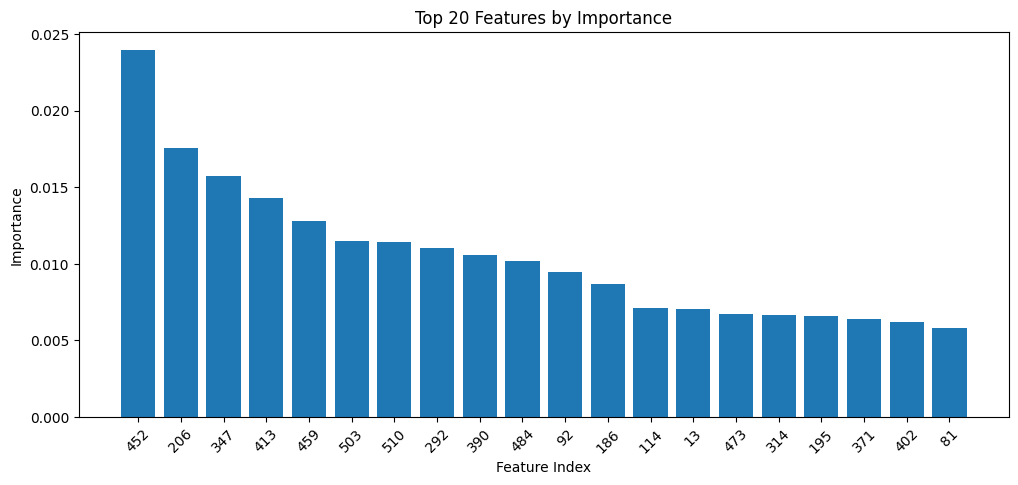

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(features, y)

# get feature importances
importances = clf.feature_importances_

# sort the features by importance in descending order
sorted_indices = np.argsort(-importances)  # Note the negative sign
sorted_importances = importances[sorted_indices]

# plot top 20 features
plt.figure(figsize=(12, 5))
plt.bar(np.arange(20), sorted_importances[:20])  # Take first 20 instead of last 20
plt.title('Top 20 Features by Importance')
plt.xticks(np.arange(20), sorted_indices[:20], rotation=45)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

## LDA

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(features, y)
reduced_embeddings = lda.transform(features)
print("Reduced embeddings shape:", reduced_embeddings.shape)


Reduced embeddings shape: (3256, 3)


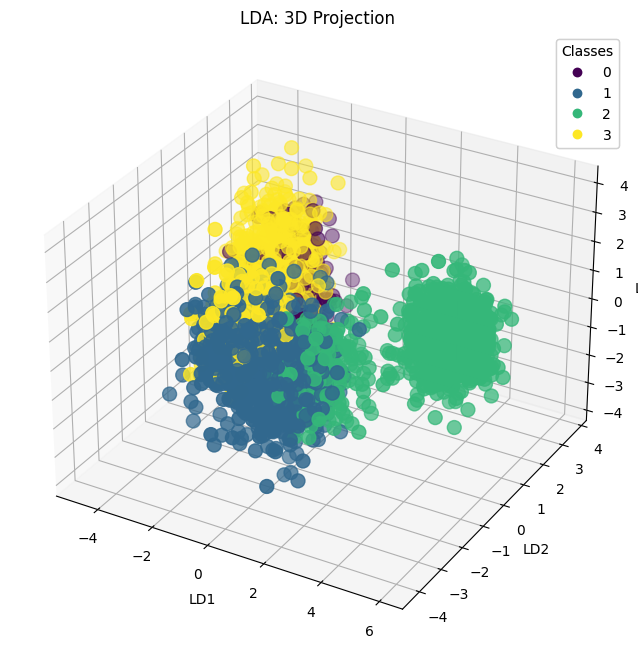

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
lda_df = pd.DataFrame(reduced_embeddings, columns=['LD1', 'LD2', 'LD3'])
lda_df['Type'] = pd.DataFrame(y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each species
scatter = ax.scatter(lda_df['LD1'], lda_df['LD2'], lda_df['LD3'],
                     c=lda_df['Type'], cmap='viridis', s=100, marker='o')

# Add labels and title
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')
ax.set_title('LDA: 3D Projection')

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=list(set(y)), title="Classes")
ax.add_artist(legend1)

plt.show()